In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL
from matplotlib import pyplot as plt

from merge.model import Model
from datasets.ICDAR.ICDAR import IcdarMerge
from utils.visualization import create_merge_result_image

In [2]:
tf.random.set_seed(42)

In [3]:
def run_model_on_random_input(model):
    batch_size = 1
    height = 100
    width = 200
    inputs = {
        'image': tf.random.uniform(shape=(batch_size, height, width, 3), minval=0, maxval=256, dtype='int32'),
        'horz_split_points_probs': tf.random.uniform(shape=(batch_size, height), dtype='float32'),
        'vert_split_points_probs': tf.random.uniform(shape=(batch_size, width), dtype='float32'),
        'horz_split_points_binary': tf.random.uniform(shape=(batch_size, height), minval=0, maxval=2, dtype='int32'),
        'vert_split_points_binary': tf.random.uniform(shape=(batch_size, width), minval=0, maxval=2, dtype='int32')
    }
    model(inputs)

In [4]:
m = Model()
run_model_on_random_input(m)
m.load_weights('checkpoints/merge.ckpt')

2022-02-09 13:09:59.128998: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-02-09 13:09:59.537408: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open checkpoints/merge.ckpt: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [5]:
ds = tfds.load('icdar_merge', split='train').shuffle(100)

In [6]:
def get_predictions(ds_element):
    input_keys = [
        'image',
        'horz_split_points_probs',
        'vert_split_points_probs',
        'horz_split_points_binary',
        'vert_split_points_binary'
    ]
    inputs = {key: tf.expand_dims(ds_element[key], 0) for key in input_keys}
    
    outputs = m(inputs)
    return (
        tf.squeeze(outputs['merge_down_probs2'] >= 0.5, 0),
        tf.squeeze(outputs['merge_right_probs2'] >= 0.5, 0)
    )

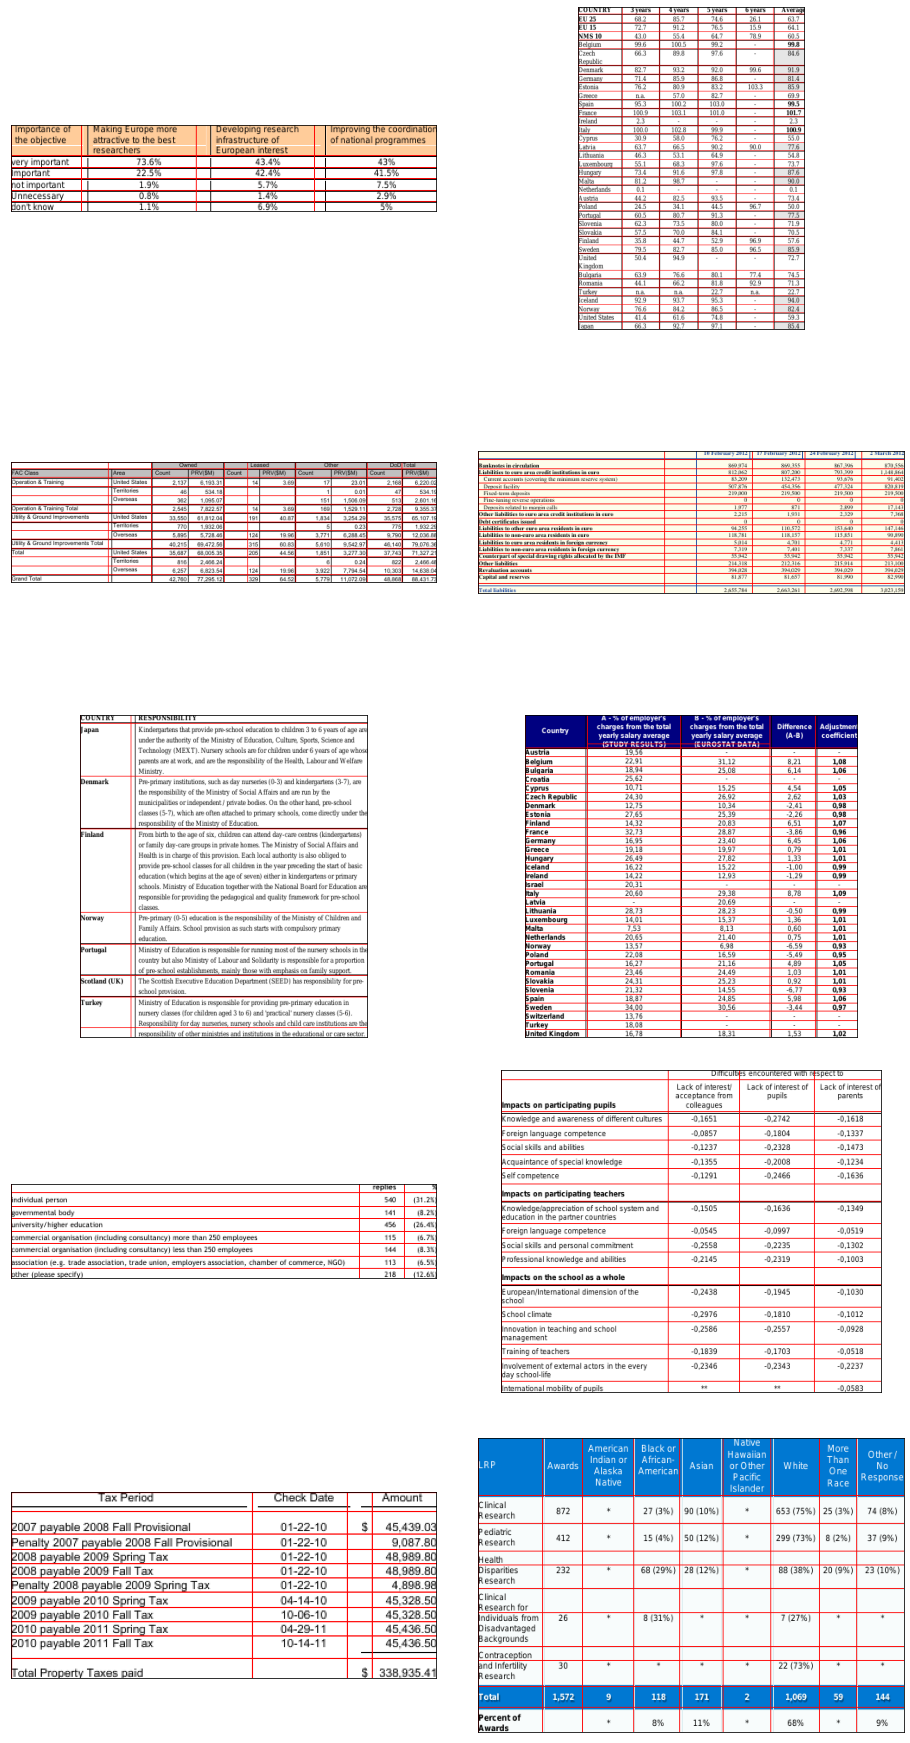

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(16,32))

for element, ax in zip(ds.take(10), axes.flat):
    merge_down_mask, merge_right_mask = get_predictions(element)
    image = PIL.Image.fromarray(element['image'].numpy())
    h_mask = element['horz_split_points_binary'].numpy()
    v_mask = element['vert_split_points_binary'].numpy()
    debug_image = create_merge_result_image(
        image, h_mask, v_mask, merge_right_mask, merge_down_mask)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(debug_image)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig('images/merge_model_predictions.png', bbox_inches='tight')
plt.show()